## 参考文献汇总
- Reference 1: Kaggle Kernel [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)
- Reference 2: Kaggle Kernel-[A Journey through Rossmann Stores](https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores)
- Reference 3: Kaggle Kernel-[Predict_sales_with_pandas](https://www.kaggle.com/zygmunt/rossmann-store-sales/predict-sales-with-pandas-py)
- Reference 4:[XGBoost:Notes on Parameter Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- Reference 5:[XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html)
- Reference 6:[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- Reference 7:[XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)


## 程序使用说明
1. 运行程序前，从[Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)官网下载数据store.csv.zip、train.csv.zip和test.csv.zip，将解压后的store.csv、train.csv、test.csv放在与本文档同目录下的data文件夹中
2. "RossmanSales_Part_01_DataPreprocessing.ipynb"会生成后续数据可视化、模型训练所需要的数据
4. "RossmanSales_Part_02_VisualExploration.ipynb"为数据可视化，需使用Part 1生成的数据
5. “RossmanSales_Part_03_BenchmarkModel.ipynb”生成基准模型，需使用Part 1生成的数据
6. “RossmanSales_Part_04_XGBoost_HyperPara_Optimization.ipynb”使用XGBoost方法训练模型，并进行超参数优化；需使用Part 1生成的数据；
7. 文件夹说明：
    - data： 保存store.csv、train.csv、test.csv
    - data_inter_transfer：保存"RossmanSales_Part_01_DataPreprocessing.ipynb"生成的数据
    - output_csv：保存用来提交到Kaggle的结果文件
    - model_saved：保存生成的模型

## 准备工作
### 0.1 调入库函数

In [1]:

#基本计算类
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

#xgboost库函数
import xgboost as xgb


#时间类
import time
import datetime
from isoweek import Week

#文件类
import os

#其他
import itertools
import operator

#基本设定

%matplotlib inline
sns.set_style('whitegrid')

### 0.2 定义评估指标
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

### 0.3 Setting seed

In [3]:
seed_1=42

## 2.数据可视化

###  2.0 将处理好的数据从本地硬盘读入

In [2]:
file_train_store_raw_df='train_store_raw_df.pickle'
file_test_store_raw_df='test_store_raw_df.pickle'

# file_feature='feature_x_list.pickle'
file_train_raw_df='train_raw_df.pickle'
file_store_raw_df='store_raw_df.pickle'
path='data_inter_transfer'

train_raw_df=pd.read_pickle(os.path.join(path, file_train_raw_df))

store_raw_df=pd.read_pickle(os.path.join(path, file_store_raw_df))

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

test_store_raw_df=pd.read_pickle(os.path.join(path, file_test_store_raw_df))


# feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()

### 2.1 Open & DayOfWeek

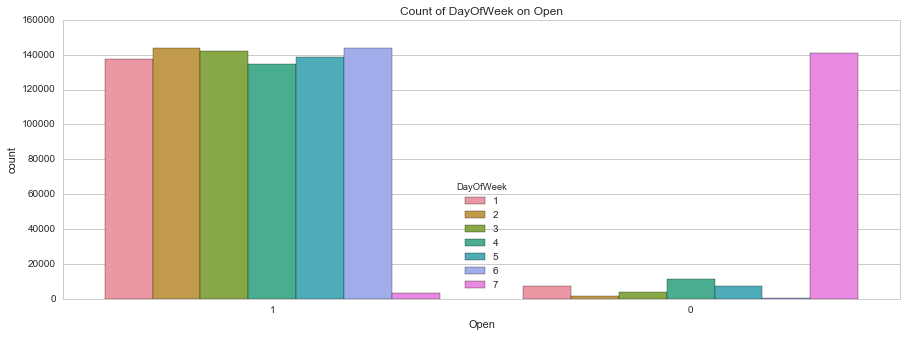

In [4]:
# Count of DayOfWeek on Open
fig,axis1=plt.subplots(1,1,figsize=(15,5))
plt.title('Count of DayOfWeek on Open')
sns.countplot(x='Open',hue='DayOfWeek',data=train_raw_df,order=[1,0])

### 2.2 Sales,Customers,SalesPerCustomer on DayOfWeek

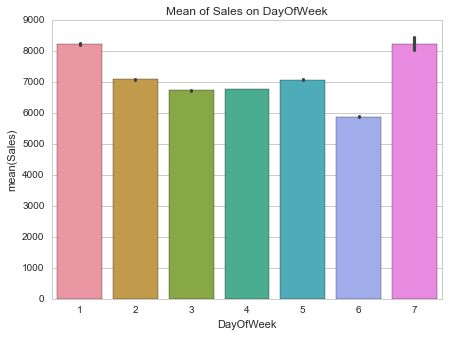

In [5]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='DayOfWeek',y='Sales',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis1).set_title("Mean of Sales on DayOfWeek")


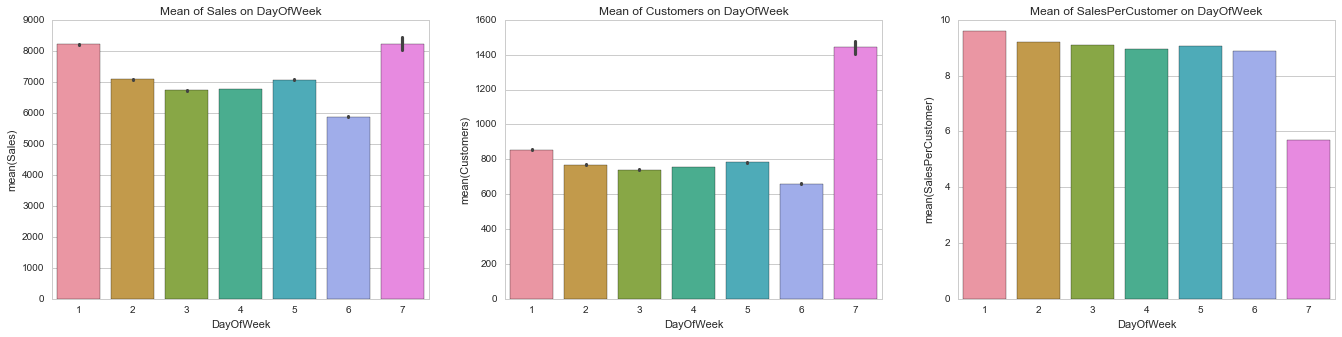

In [6]:
# mean of Sales,Customers,SalesPerCustomer on DayOfWeek(Only the open==1 is calculated)
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))
sns.barplot(x='DayOfWeek',y='Sales',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis1).set_title("Mean of Sales on DayOfWeek")
sns.barplot(x='DayOfWeek',y='Customers',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis2).set_title("Mean of Customers on DayOfWeek")

#calc the SalesPerCustomer
temp=(train_raw_df.loc[train_raw_df.Open==1])[['Sales','Customers','DayOfWeek']].groupby('DayOfWeek').sum()
temp['SalesPerCustomer']=temp['Sales']/temp['Customers']
sns.barplot(x=temp.index,y='SalesPerCustomer',data=temp,order=[1,2,3,4,5,6,7],ax=axis3).set_title("Mean of SalesPerCustomer on DayOfWeek")

### 2.3 Sales,Customers,SalesPerCustomer on Promo

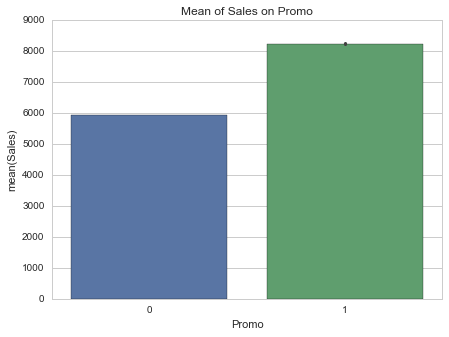

In [7]:
# Sales,Customers on Promo vs Non-Promo
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='Promo',y='Sales',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis1).set_title("Mean of Sales on Promo")

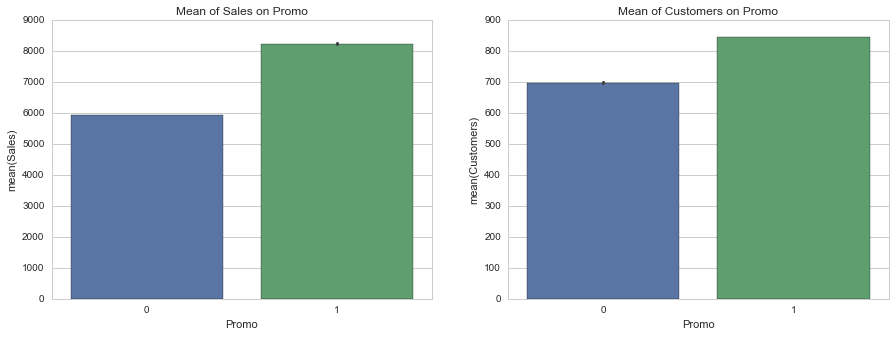

In [8]:
# Sales,Customers on Promo vs Non-Promo
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='Promo',y='Sales',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis1).set_title("Mean of Sales on Promo")
sns.barplot(x='Promo',y='Customers',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis2).set_title("Mean of Customers on Promo")

(array([0, 1]), <a list of 2 Text xticklabel objects>)

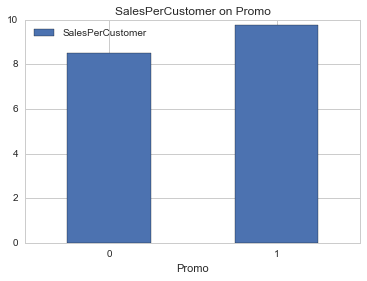

In [9]:
# SalesPerCustomers on Promo vs Non-Promo
temp=(train_raw_df.loc[train_raw_df.Open==1])[['Sales','Customers','Promo']].groupby('Promo').sum()
temp['SalesPerCustomer']=temp['Sales']/temp['Customers']
temp.plot(kind='bar', x=temp.index,y='SalesPerCustomer',title='SalesPerCustomer on Promo')
plt.xticks(rotation='horizontal')

### 2.4 Count of StateHoliday & Average Sales/Customers of StateHoliday 

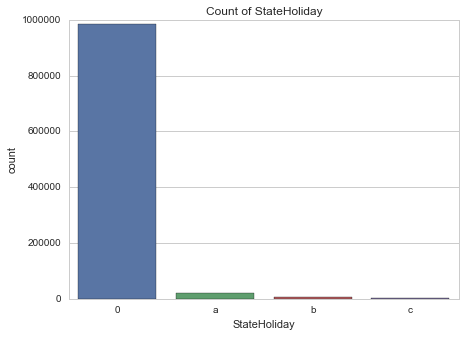

In [10]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))

#Count of StateHoliday
sns.countplot(x='StateHoliday',data=train_raw_df,ax=axis1).set_title("Count of StateHoliday")

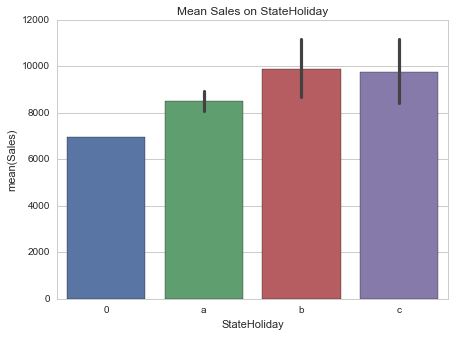

In [11]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))


#Average Sales of StateHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='StateHoliday',y='Sales',data=train_raw_df[mask],ax=axis1).set_title("Mean Sales on StateHoliday")


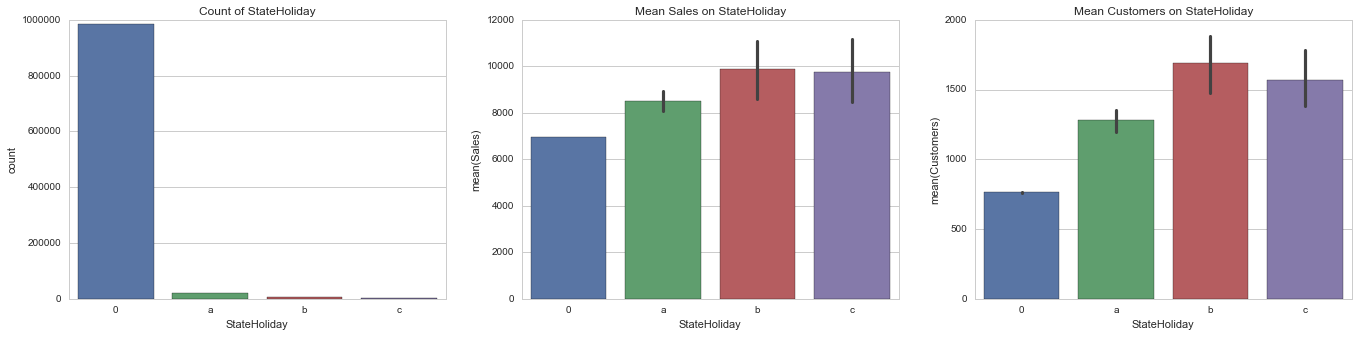

In [12]:
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))

#Count of StateHoliday
sns.countplot(x='StateHoliday',data=train_raw_df,ax=axis1).set_title("Count of StateHoliday")

#Average Sales of StateHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='StateHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on StateHoliday")
sns.barplot(x='StateHoliday',y='Customers',data=train_raw_df[mask],ax=axis3).set_title("Mean Customers on StateHoliday")

### 2.5 Count of SchoolHoliday & Average Sales/Customers of SchoolHoliday 

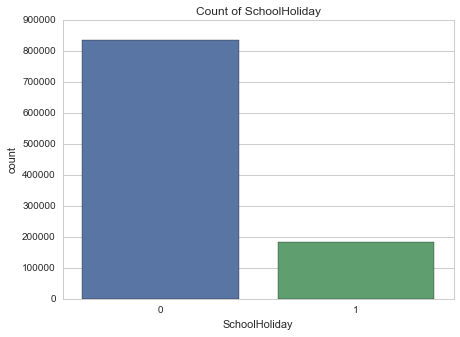

In [13]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))

#Count of SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train_raw_df,ax=axis1).set_title("Count of SchoolHoliday")

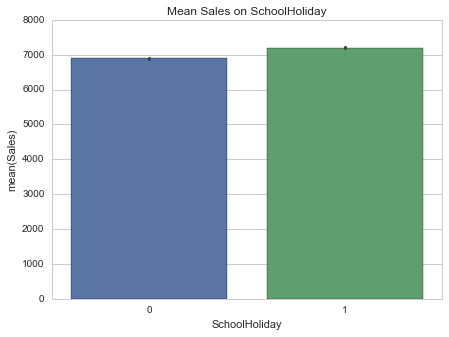

In [14]:
fig,(axis2)=plt.subplots(1,1,figsize=(7,5))


#Average Sales of SchoolHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='SchoolHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on SchoolHoliday")


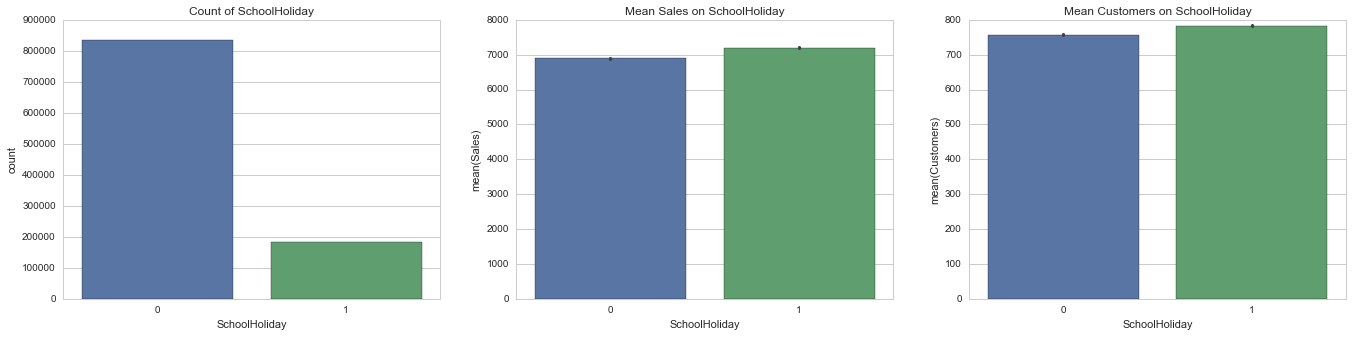

In [15]:
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))

#Count of SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train_raw_df,ax=axis1).set_title("Count of SchoolHoliday")

#Average Sales of SchoolHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='SchoolHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on SchoolHoliday")
sns.barplot(x='SchoolHoliday',y='Customers',data=train_raw_df[mask],ax=axis3).set_title("Mean Customers on SchoolHoliday")

### 2.6 Sales/Customers distribution & change over time

#### 2.6.1 Sales/Customers distribution

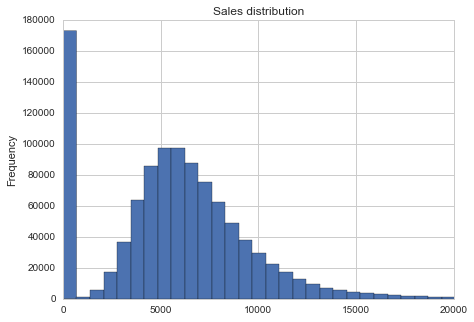

In [16]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =train_raw_df['Sales'].plot(kind='hist',bins=60,xlim=(0,20000),ax=axis1,title='Sales distribution')


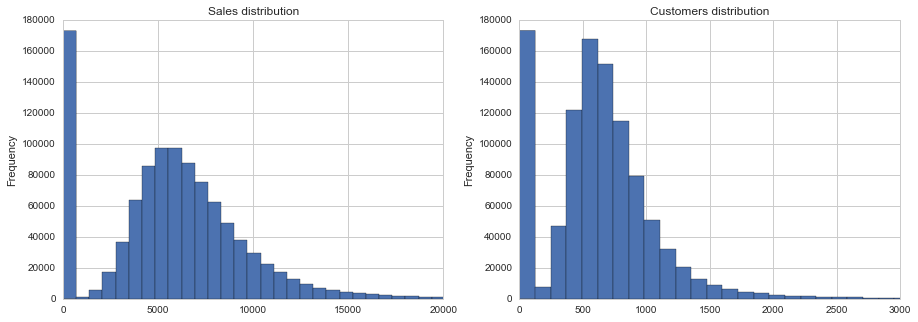

In [17]:
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
#Sales
_ =train_raw_df['Sales'].plot(kind='hist',bins=60,xlim=(0,20000),ax=axis1,title='Sales distribution')
#Customers
_ =train_raw_df['Customers'].plot(kind='hist',bins=60,xlim=(0,3000),ax=axis2,title='Customers distribution')

#### 2.6.2 Boxplot of Sales/Customers

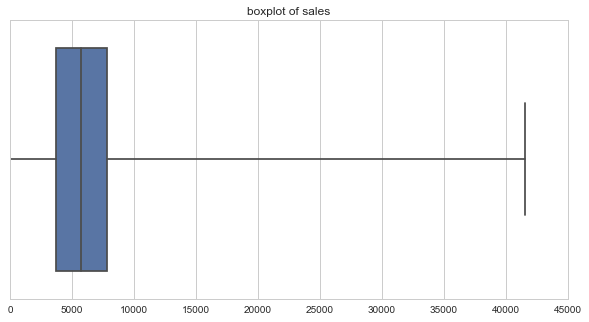

In [18]:
# plot boxplot of sales
fig,(axis1)=plt.subplots(1,1,figsize=(10,5))
_ =sns.boxplot([train_raw_df['Sales']],whis=np.inf,ax=axis1).set_title('boxplot of sales')


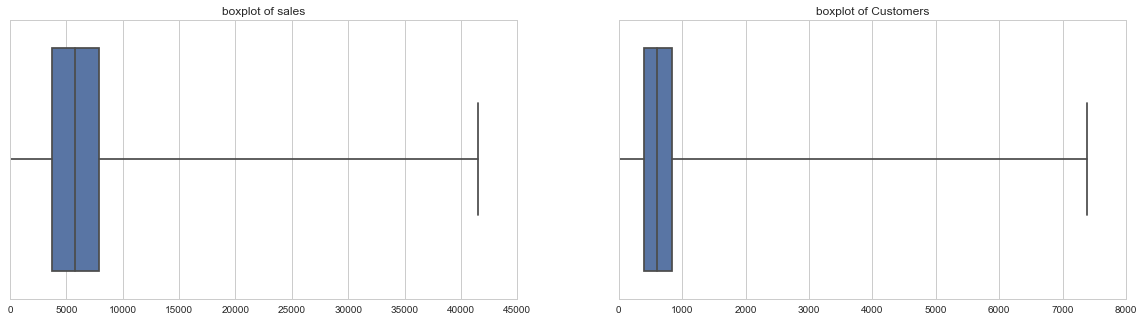

In [19]:
# plot boxplot of sales
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(20,5))
_ =sns.boxplot([train_raw_df['Sales']],whis=np.inf,ax=axis1).set_title('boxplot of sales')
_ =sns.boxplot([train_raw_df['Customers']],whis=np.inf,ax=axis2).set_title('boxplot of Customers')

#### 2.6.3 Sales/Customer Average over year

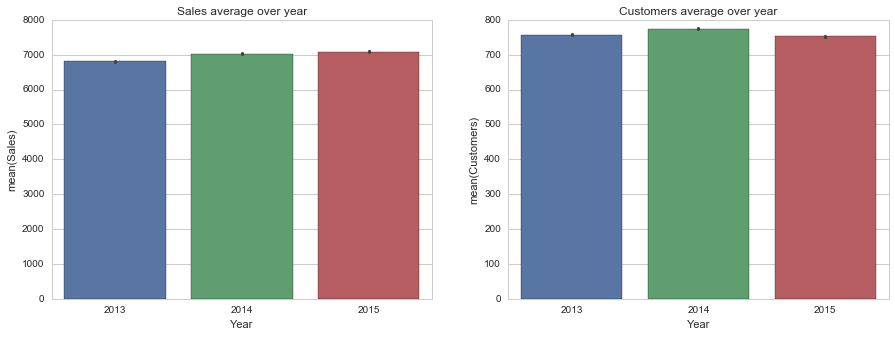

In [20]:
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))

mask=(train_raw_df['Open']==1)
_ =sns.barplot(x='Year',y='Sales',data=train_raw_df[mask],ax=axis1).set_title("Sales average over year")

_ =sns.barplot(x='Year',y='Customers',data=train_raw_df[mask],ax=axis2).set_title("Customers average over year")

#### 2.6.4 Sales over month

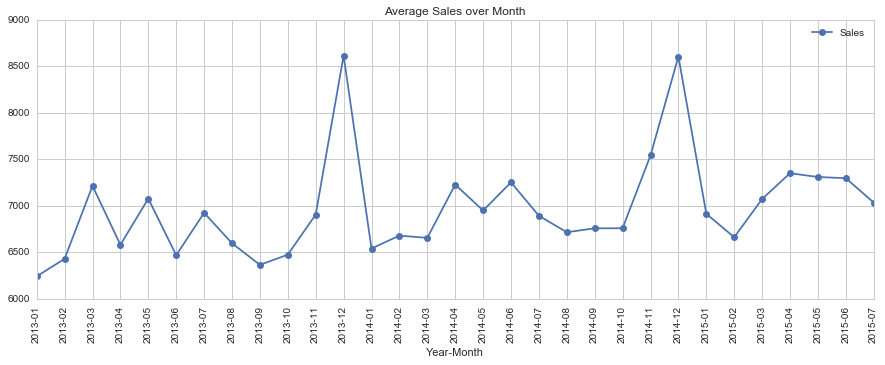

In [21]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].mean()
pct_change_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].sum().pct_change()

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales over time(year-month)
ax1=average_sales.plot(legend=True,ax=axis1,marker='o',title='Average Sales over Month')
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(),rotation=90)



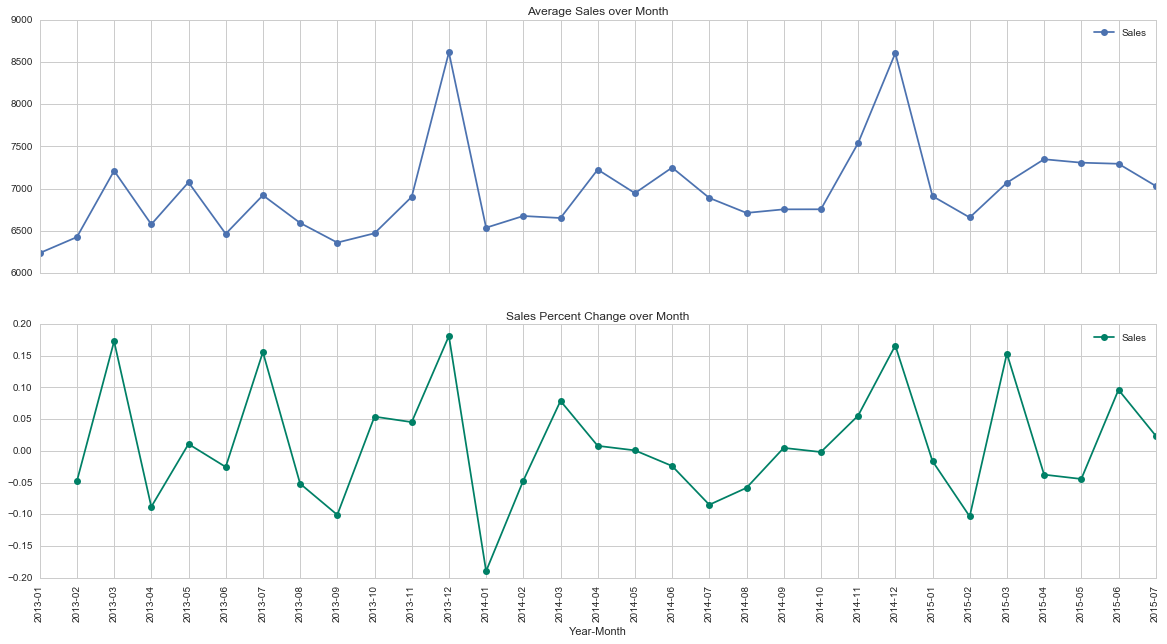

In [22]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].mean()
pct_change_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].sum().pct_change()

fig,(axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(20,10))

#plot average sales over time(year-month)
ax1=average_sales.plot(legend=True,ax=axis1,marker='o',title='Average Sales over Month')
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(),rotation=90)

#plot percent change for sales over time
ax2=pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap='summer',title='Sales Percent Change over Month')


#### 2.6.5 Customers over month

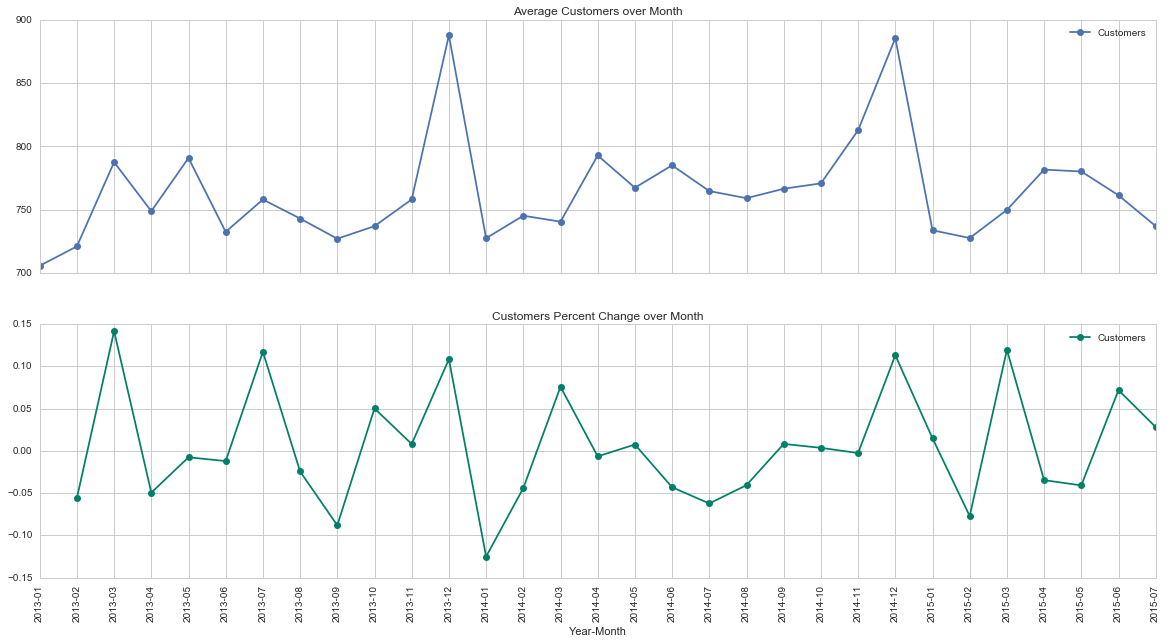

In [23]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_customers=train_raw_df[mask].groupby('Year-Month')['Customers'].mean()
pct_change_customers=train_raw_df[mask].groupby('Year-Month')['Customers'].sum().pct_change()

fig,(axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(20,10))

#plot average sales over time(year-month)
ax1=average_customers.plot(legend=True,ax=axis1,marker='o',title='Average Customers over Month')
ax1.set_xticks(range(len(average_customers)))
ax1.set_xticklabels(average_customers.index.tolist(),rotation=90)

#plot percent change for sales over time
ax2=pct_change_customers.plot(legend=True,ax=axis2,marker='o',rot=90,colormap='summer',title='Customers Percent Change over Month')


### 2.7 StoreType: count & average sales/customers

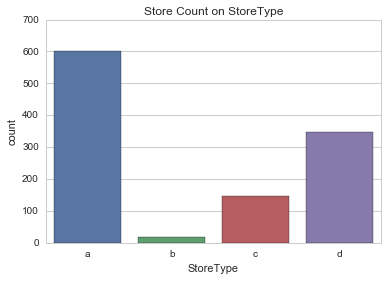

In [24]:
#count of StoreType
_ =sns.countplot(x='StoreType',order=['a','b','c','d'],data=store_raw_df).set_title('Store Count on StoreType')


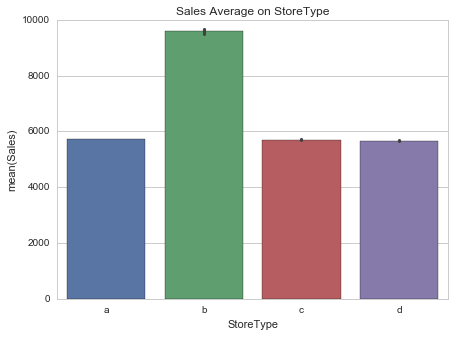

In [25]:
# average sales/customers on StoreType
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='StoreType',y='Sales',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis1).set_title('Sales Average on StoreType')


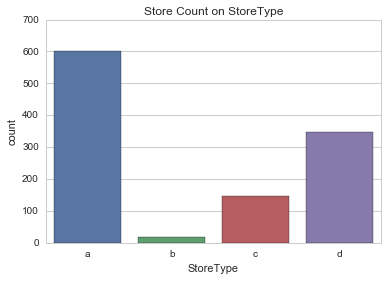

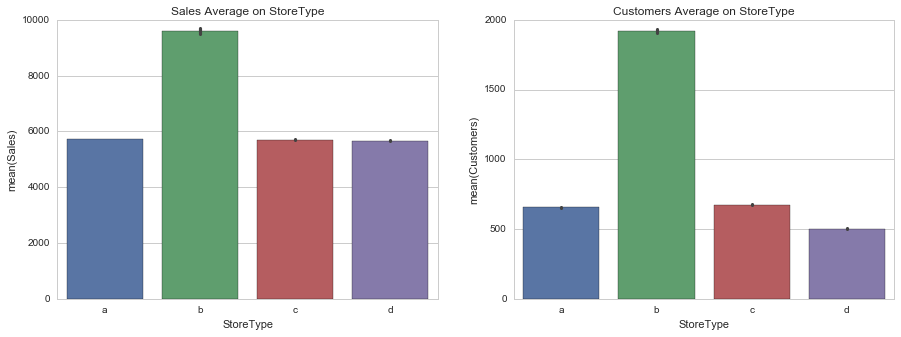

In [26]:
#count of StoreType
_ =sns.countplot(x='StoreType',order=['a','b','c','d'],data=store_raw_df).set_title('Store Count on StoreType')
# average sales/customers on StoreType
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='StoreType',y='Sales',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis1).set_title('Sales Average on StoreType')
sns.barplot(x='StoreType',y='Customers',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis2).set_title('Customers Average on StoreType')

### 2.8 Assortment: count & average sales/customers

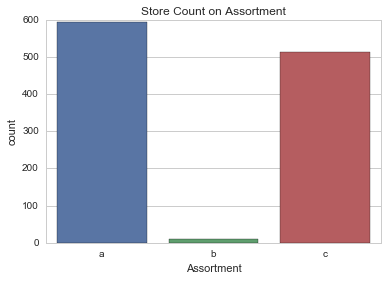

In [27]:
#count of Assortment
_ =sns.countplot(x='Assortment',order=['a','b','c'],data=store_raw_df).set_title('Store Count on Assortment')


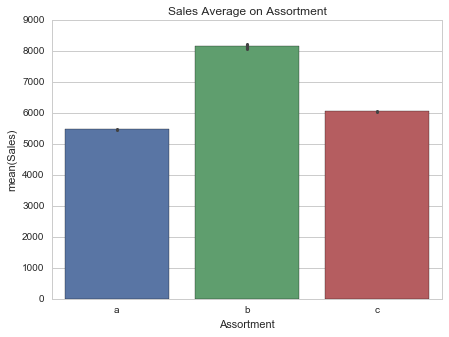

In [28]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='Assortment',y='Sales',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis1).set_title('Sales Average on Assortment')


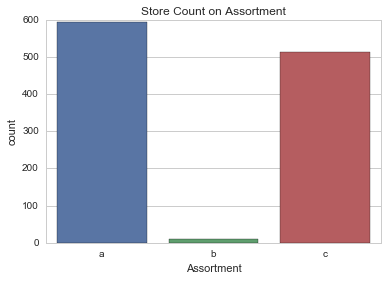

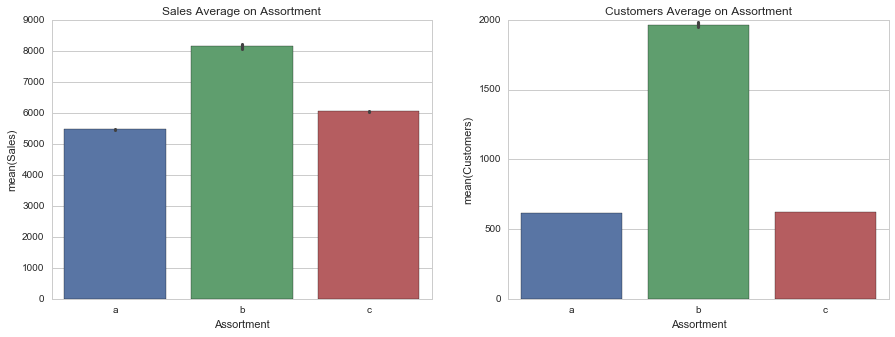

In [29]:
#count of Assortment
_ =sns.countplot(x='Assortment',order=['a','b','c'],data=store_raw_df).set_title('Store Count on Assortment')
# average sales/customers on Assortment
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='Assortment',y='Sales',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis1).set_title('Sales Average on Assortment')
sns.barplot(x='Assortment',y='Customers',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis2).set_title('Customers Average on Assortment')

### 2.9 Competition: 
#### 2.9.1 Competition Distance

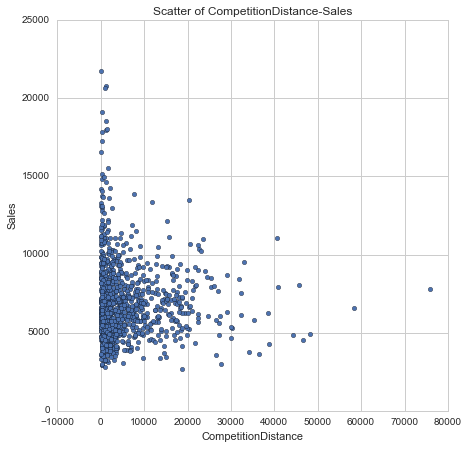

In [30]:
# Plot CompetitionDistance vs Sales
fig,(axis1)=plt.subplots(1,1,figsize=(10,10))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()
temp.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(7,7),ax=axis1).set_title('Scatter of CompetitionDistance-Sales')

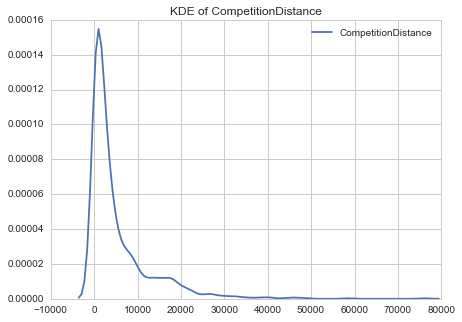

In [31]:
# Plot CompetitionDistance vs Sales
fig,(axis2)=plt.subplots(1,1,figsize=(7,5))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()


sns.kdeplot(temp['CompetitionDistance'],ax=axis2).set_title('KDE of CompetitionDistance')


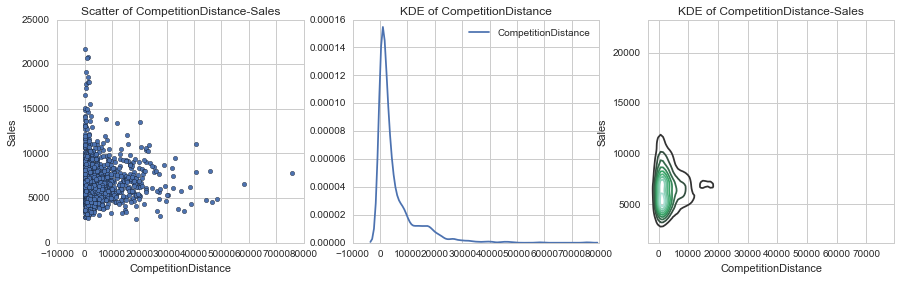

In [32]:
# Plot CompetitionDistance vs Sales
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()
temp.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),ax=axis1).set_title('Scatter of CompetitionDistance-Sales')

sns.kdeplot(temp['CompetitionDistance'],ax=axis2).set_title('KDE of CompetitionDistance')
sns.kdeplot(temp['CompetitionDistance'],temp['Sales'],ax=axis3).set_title('KDE of CompetitionDistance-Sales')

#### 2.9.2 the Competition's effect on Sales

In [33]:
# 挑选出Competition出现在train数据时间段范围内
mask=(train_store_raw_df.CompetitionSinceDate>train_store_raw_df.Date_time.min())&(train_store_raw_df.CompetitionSinceDate<train_store_raw_df.Date_time.max())
temp_store_list=train_store_raw_df[mask].Store.unique()
temp_store_list

array([   5,    6,    7,    8,   14,   28,   30,   33,   37,   45,   47,
         51,   52,   53,   54,   57,   75,   84,   95,  103,  106,  110,
        116,  120,  122,  126,  131,  133,  137,  138,  159,  166,  169,
        170,  181,  185,  189,  191,  197,  213,  214,  219,  221,  225,
        230,  246,  249,  261,  262,  263,  264,  266,  268,  269,  270,
        275,  276,  280,  286,  301,  304,  315,  317,  318,  321,  326,
        336,  347,  355,  361,  369,  375,  380,  386,  391,  395,  403,
        413,  416,  423,  428,  432,  447,  449,  452,  461,  488,  489,
        490,  496,  506,  513,  518,  523,  524,  525,  539,  550,  551,
        555,  556,  560,  563,  578,  581,  585,  595,  598,  599,  601,
        604,  608,  626,  629,  630,  635,  646,  647,  653,  661,  675,
        677,  683,  685,  706,  715,  718,  730,  740,  745,  752,  770,
        774,  784,  788,  800,  801,  810,  814,  819,  828,  837,  839,
        859,  872,  878,  882,  901,  902,  903,  9

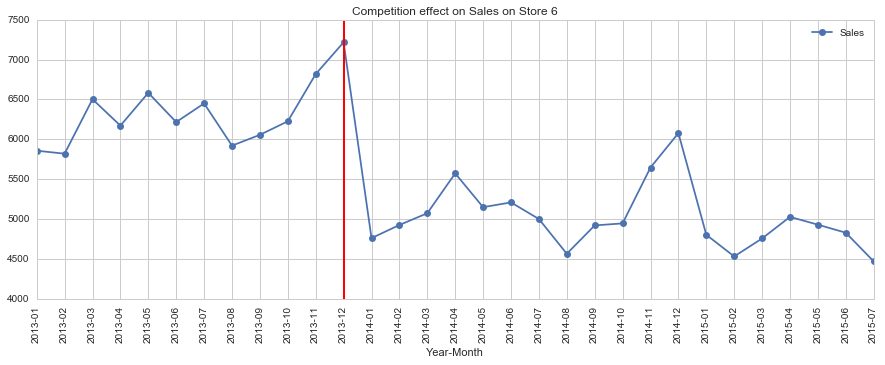

In [34]:
# 挑出三个store_id，并绘制出销售额Sales与Competition的关系
picked_order=[1]
picked_store=list (temp_store_list[i] for i in picked_order)
mask=(train_store_raw_df['Open']==1)
for ii in picked_store:
    mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['Store']==ii)
    store_id_data=train_store_raw_df.loc[mask]
    store_sell_data=store_id_data[['Year-Month','Sales']].groupby('Year-Month')['Sales'].mean()
    ax1=store_sell_data.plot(legend=True,marker='o',title='Competition effect on Sales on Store {}'.format(ii),figsize=(15,5))
    _=ax1.set_xticks(range(len(store_sell_data)) )
    _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
    # Get year and month when competition started
    m=store_id_data.CompetitionOpenSinceMonth.values[0]
    y=store_id_data.CompetitionOpenSinceYear.values[0]

    plt.axvline(x=(y-2013)*12+(m-1),linewidth=2,color='red')
    plt.show()

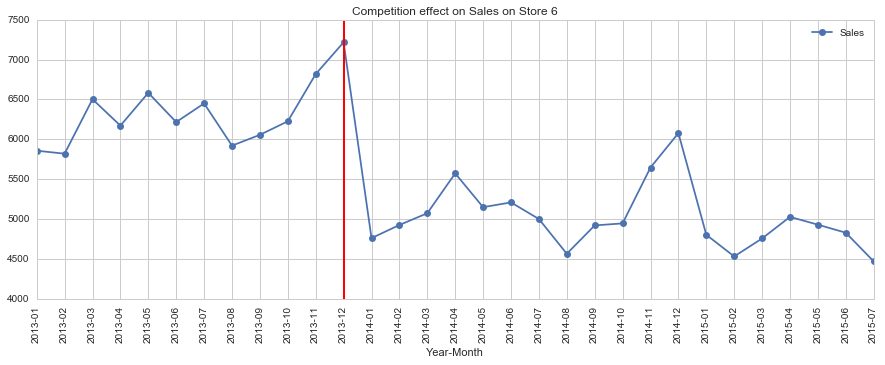

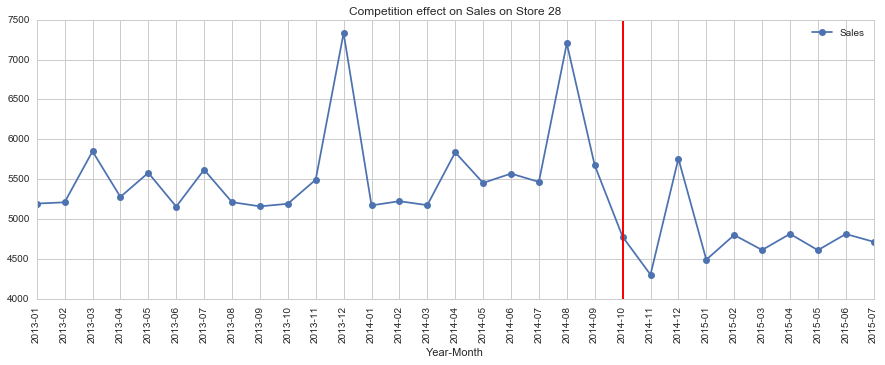

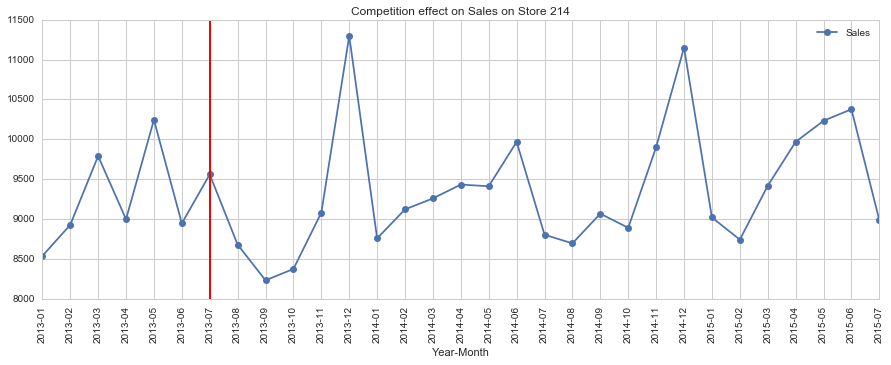

In [35]:
# 挑出三个store_id，并绘制出销售额Sales与Competition的关系
picked_order=[1,5,40]
picked_store=list (temp_store_list[i] for i in picked_order)
mask=(train_store_raw_df['Open']==1)
for ii in picked_store:
    mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['Store']==ii)
    store_id_data=train_store_raw_df.loc[mask]
    store_sell_data=store_id_data[['Year-Month','Sales']].groupby('Year-Month')['Sales'].mean()
    ax1=store_sell_data.plot(legend=True,marker='o',title='Competition effect on Sales on Store {}'.format(ii),figsize=(15,5))
    _=ax1.set_xticks(range(len(store_sell_data)) )
    _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
    # Get year and month when competition started
    m=store_id_data.CompetitionOpenSinceMonth.values[0]
    y=store_id_data.CompetitionOpenSinceYear.values[0]

    plt.axvline(x=(y-2013)*12+(m-1),linewidth=2,color='red')
    plt.show()

### 2.10 Promo2
#### 2.10.1 Sales/Customers on InPromo2Today

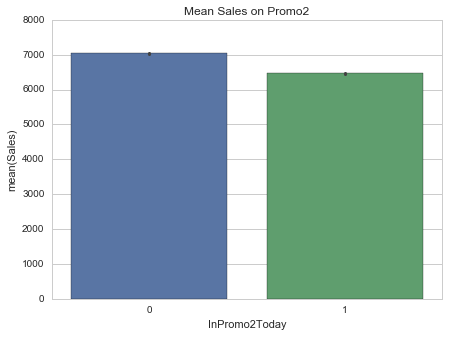

In [36]:
#为研究Promo2的影响，只选取那些Promo2=1的store在Open=1,Promo2开始后的数据进行分析
mask=(train_store_raw_df['Open']==1)
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='InPromo2Today',y='Sales',ax=axis1,data=train_store_raw_df[mask]).set_title('Mean Sales on Promo2')


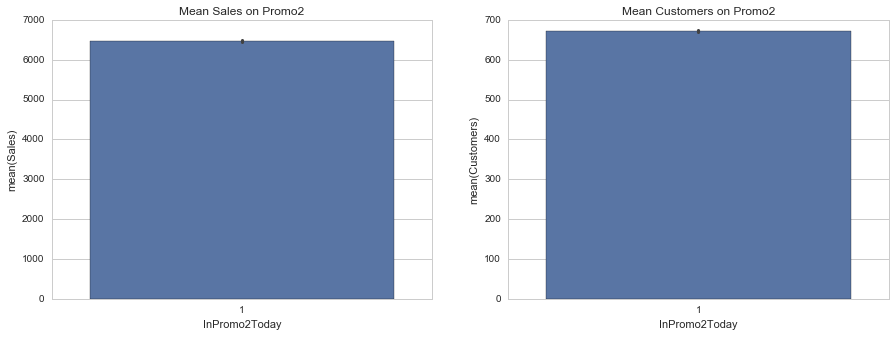

In [37]:
#为研究Promo2的影响，只选取那些Promo2=1的store在Open=1,Promo2开始后的数据进行分析
mask=(train_store_raw_df['Promo2']==1)&(train_store_raw_df['DaysCountSincePromo2']>0)&(train_store_raw_df['Open']==1)
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='InPromo2Today',y='Sales',ax=axis1,data=train_store_raw_df[mask]).set_title('Mean Sales on Promo2')
sns.barplot(x='InPromo2Today',y='Customers',ax=axis2,data=train_store_raw_df[mask]).set_title('Mean Customers on Promo2')

#### 2.10.2 Sales/Customers on Promo2 

/Users/pengjuzhao/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:545: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markevery != every:


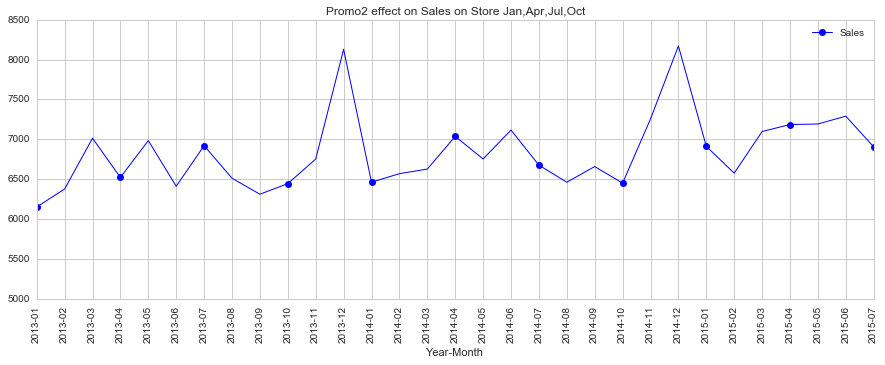

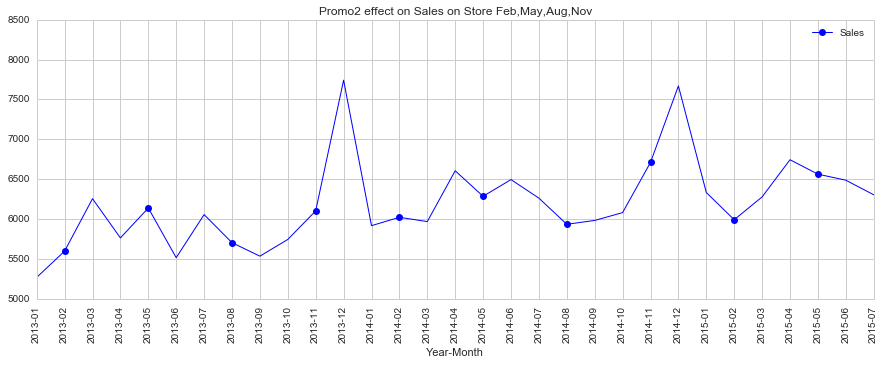

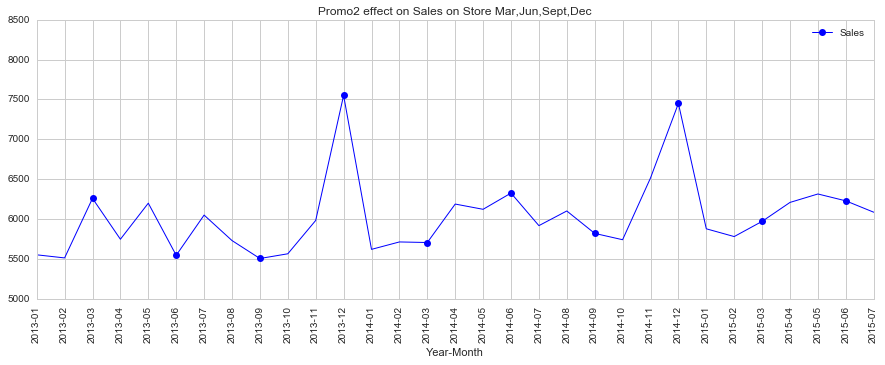

In [38]:
#选取那些Promo2SinceDate在train开始前之前的数据进行分析
mask1=(pd.to_datetime(train_store_raw_df.Promo2SinceDate)>train_store_raw_df.Date_time.min()
     )&(train_store_raw_df.Open==1)&(train_store_raw_df.Promo2==1)
Interval=train_store_raw_df['PromoInterval'].unique()

mon_map={
    'Jan,Apr,Jul,Oct':0,
    'Feb,May,Aug,Nov':1,
    'Mar,Jun,Sept,Dec':2
  }
for ii in Interval:
    if ii!='':
        fig,(axis1)=plt.subplots(1,1,figsize=(15,5))
        mask=mask1&(train_store_raw_df['PromoInterval']==ii)
        temp=train_store_raw_df.loc[mask][['Year-Month','Sales']].groupby('Year-Month').mean()
        
        x_list=range(len(store_sell_data))
        markers_on=np.array(x_list)[np.mod(x_list,3)==mon_map[ii]]
        ax1=temp.plot(linestyle='-', marker='o', color='b',linewidth=1,legend=True,markevery=markers_on,title='Promo2 effect on Sales on Store {}'.format(ii),ax=axis1,ylim=[5000,8500])
        _=ax1.set_xticks(range(len(store_sell_data)) )
        _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
                
        plt.show()
        


### 2.11 Outlier异常值

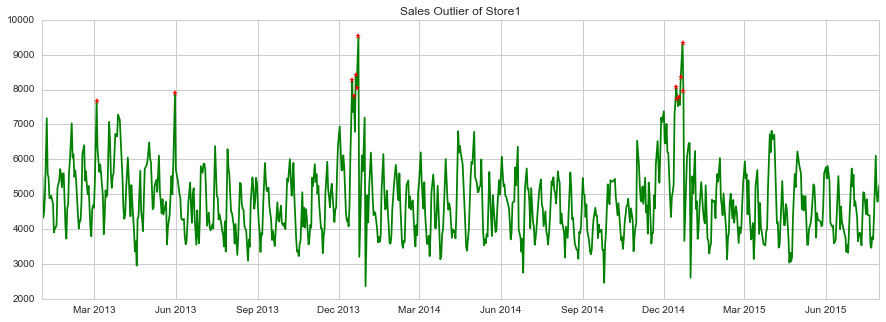

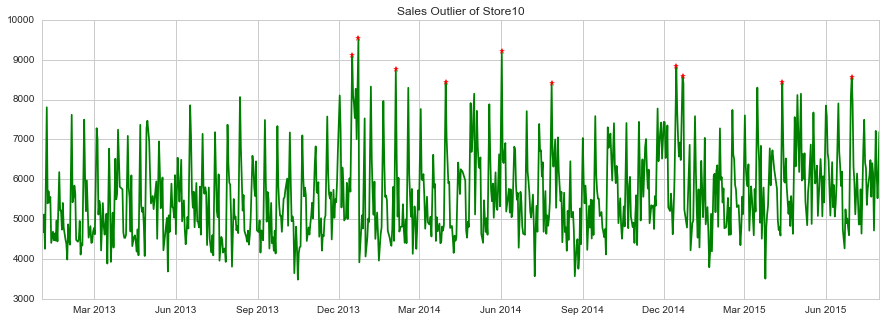

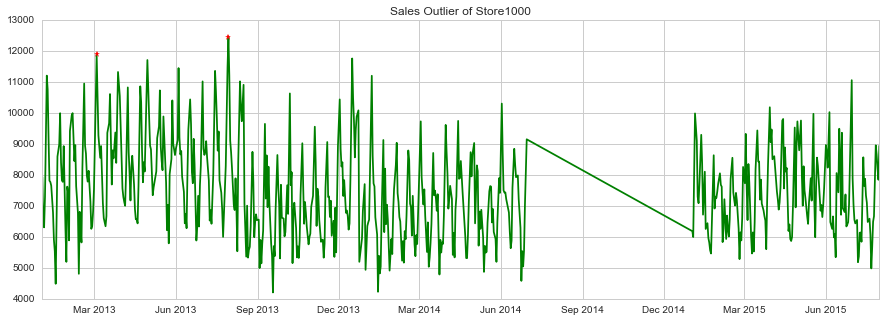

In [13]:
store_id_list=[1,10,1000]
for store_id in store_id_list:
    mask=(train_store_raw_df.Store==store_id) & (train_store_raw_df.Open==1)
    plt.figure(figsize=[15,5])
    plt.plot(train_store_raw_df.loc[mask,['Date_time','Sales']].set_index('Date_time'),'g-')

    mask_outlier=(train_store_raw_df.Store==store_id) & (train_store_raw_df.Open==1) &(train_store_raw_df.Outlier_3==1)

    plt.plot(train_store_raw_df.loc[mask_outlier,['Date_time','Sales']].set_index('Date_time'),'r*')
    plt.title('Sales Outlier of Store'+str(store_id))
    plt.show()

In [14]:
mask=(train_store_raw_df.Store==1000) &(train_store_raw_df.Date_time>'2014-08-15')&(train_store_raw_df.Date_time<'2015-01-01')
train_store_raw_df.loc[mask,['Date','Sales']]

,Date,Sales
